# [NLP] Assignment 1: Tokenization

In this assignment, you need to tokenize the text of the Twitter(X) users posts(tweets). The assignment consists of two tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repo later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

The [data](https://drive.google.com/file/d/15x_wPAflvYQ2Xh38iNQGrqUIWLj5l5Nw/view?usp=share_link) contains 5 files whereby each contains 44 tweets. Each tweet is separated by a newline.

## Task 1. Tokenize some tweets manually (20 points)

As a first task you need to tokenize first 15 tweets from `file2` by hand. This will allow you to understand the problem from a linguistic point of view. The guidelines for tweet tokenization are as follows:

- Each smiley is a separate token
- Each hashtag is an individual token. Each user reference is an individual token
- If a word has spaces between them then it is converted to a single token
- All punctuations are individual tokens. This includes double-quotes and single quotes also
- A URL is a single token

Example of output

    Input tweet
    @xfranman Old age has made N A T O!

    Tokenized tweet (separated by comma)
    @xfranman , Old , age , has , made , NATO , !


    1. Input tweet
    ...
    1. Tokenized tweet
    ...

    2. Input tweet
    ...
    2. Tokenized tweet
    ...

## Task 2. Implement [Byte-Pair Encoding(BPE)](https://arxiv.org/pdf/1508.07909.pdf) Tokenizer (80 points)

### Task 2.1. Implementation (60 points)

Implement the tokenizer as the BPETokenizer class:
* Implement `train` method that learns merges and builds the vocabulary of the specified `vocab_size` (25 points).
* Implement `tokenize` method that should tokenize the text according to the learnt merges (25 points).

Your code should have docstrings and comments (10 points).

In [4]:
!gdown https://drive.google.com/file/d/15x_wPAflvYQ2Xh38iNQGrqUIWLj5l5Nw/view?usp=share_link --fuzzy

Downloading...
From: https://drive.google.com/uc?id=15x_wPAflvYQ2Xh38iNQGrqUIWLj5l5Nw
To: /content/Assignment1_data.zip
100% 15.6k/15.6k [00:00<00:00, 35.3MB/s]


In [6]:
!unzip Assignment1_data.zip -d data

Archive:  Assignment1_data.zip
  inflating: data/file5              
  inflating: data/__MACOSX/._file5   
  inflating: data/file4              
  inflating: data/__MACOSX/._file4   
  inflating: data/file3              
  inflating: data/__MACOSX/._file3   
  inflating: data/file2              
  inflating: data/__MACOSX/._file2   
  inflating: data/file1              
  inflating: data/__MACOSX/._file1   


In [30]:
from typing import List
import nltk
nltk.download('punkt', quiet=True)

class BPETokenizer:

    def __init__(self, vocab_size: int) -> None:
        """
            Init function to set vocab_size
        """
        self.vocab_size = vocab_size


    def train(self, corpus: List[str]) -> None:
        """
            Main function to train BPE
        """
        self.word_frequency = {}
        self.vocab = []
        self.tokenized = {}

        for line in corpus:
            words = nltk.word_tokenize(line)
            for word in words:
                if word not in self.word_frequency:
                    self.word_frequency[word] = 0
                self.word_frequency[word] += 1

        for word in self.word_frequency:
            self.tokenized[word] = []
            for i in range(len(word)):
                c = word[i]
                if c not in self.vocab:
                    self.vocab.append(c)
                self.tokenized[word].append(c)

        num_it = max(0, self.vocab_size - len(self.vocab))
        self.num_it = num_it
        for _ in range(num_it):
            best_pair = self.get_most_freq_pair()
            if best_pair is None:
                break
            self.vocab.append(best_pair)
            self.add(best_pair[0], best_pair[1])

    def add(self, part1, part2):
        """
            Add new pair of (part1, part2) to BPE
        """
        for word, freq in self.word_frequency.items():
            tokens = self.tokenized[word]
            i = 0
            while i + 1 < len(tokens):
                if tokens[i] == part1 and tokens[i + 1] == part2:
                    tokens = tokens[:i] + [part1 + part2] + tokens[i + 2:]
                else:
                    i += 1
            self.tokenized[word] = tokens

    def get_most_freq_pair(self):
        """
            Return the most frequency pair of tokenized words
        """
        bp = {}
        for word, freq in self.word_frequency.items():
            tokens = self.tokenized[word]
            for i in range(len(tokens) - 1):
                if (tokens[i], tokens[i + 1]) not in bp:
                    bp[(tokens[i], tokens[i + 1])] = 0
                bp[(tokens[i], tokens[i + 1])] += freq

        best_pair = None
        max_freq = -1
        for pair, freq in bp.items():
            if freq > max_freq:
                max_freq = freq
                best_pair = pair

        return best_pair


    def tokenize(self, text: str) -> List[str]:
        """
            Return the tokenized text
        """
        words = nltk.word_tokenize(text)
        res = []
        for word in words:
            tokens = []
            for c in word:
                tokens.append(c)
            for i in range(self.vocab_size - self.num_it, self.vocab_size):
                pair = self.vocab[i]

                j = 0
                while j + 1 < len(tokens):
                    if tokens[j] == pair[0] and tokens[j + 1] == pair[1]:
                        tokens = tokens[:j] + [pair[0] + pair[1]] + tokens[j + 2:]
                    else:
                        j += 1
            res.extend(tokens)

        return res

### Task 2.2. Analysis on Tweets Dataset (10 points)

Train the BPE tokenizer on the tweets dataset. Try to tokenize the tweets with the tokenizer of different `vocab_size`. For example, train the BPE tokenizer with `vocab_size` of [base_vocab_size, 250, 500, 750, 1000]. Plot the dependency of the average length of the tokenized tweet by `vocab_size` to analyze how `vocab_size` affects the length of the tokenized tweet on average. Tell what `vocab_size` is preferrable and why.

In [11]:
import os

data = []

for i in range(1, 6):
    path = f"data/file{i}"
    with open(path, 'r') as f:
        data.extend(f.readlines())

In [31]:
vocab_sizes = [100, 250, 500, 750, 1000]
average_length = []
for vocab_size in vocab_sizes:
    bpe = BPETokenizer(vocab_size=vocab_size)
    bpe.train(data)
    tokenized = []
    for sent in data:
        tokenized.extend(bpe.tokenize(sent))


    lengths = [len(t) for t in tokenized]
    average_length.append(sum(lengths) / len(lengths))

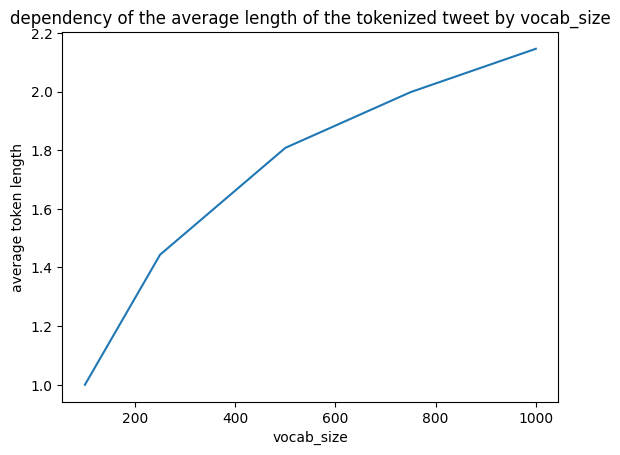

In [32]:
import matplotlib.pyplot as plt

plt.plot(vocab_sizes, average_length)
plt.title('dependency of the average length of the tokenized tweet by vocab_size')
plt.xlabel('vocab_size')
plt.ylabel('average token length')
plt.show()

### Task 2.3. Analysis on Dataset of Different Language (10 points)

Find a small dataset of texts in a language other than English. The dataset size should be not greater than several megabytes.

Train the BPE tokenizer on the dataset that you found. Try to tokenize the sentences from this dataset with the tokenizer of different `vocab_size`. Plot the dependency of the average length of the tokenized sentence by `vocab_size` to analyze how `vocab_size` affects the length of the tokenized sentence on average.

Tell how how the average length of the tokenized sentence differs from the average length of the tokenized tweet. Explain why.

In [ ]:
# Your code here